[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Redes_Neuronales_Scratch/blob/main/semana4/Ridge_&_RN_Dropout.ipynb)

# Módulos (Dependencias)

In [ ]:
import math
import numpy as np

# Red de la clase pasada

# Regresión penalizada (Ridge)

In [ ]:
def l2_penalty(w):
  return  (w**2).sum() 

In [ ]:
# Nuestra función de perdida (Error cuadrátio medio)
def ridge(y_hat, y, w):
    return np.mean((y - y_hat)**2 + 0.3 * l2_penalty(w)) # Aqui el termino constante es la lambda de regularización

def d_ridge(y_hat, y):
    return (1 / y_hat.shape[0]) * (1/y_hat.shape[-1]) * -2 * np.sum(y - y_hat, axis=0)

In [ ]:
def linear(x):
    return x


def d_linear(x):
    return np.ones_like(x)


def relu(x):
    return np.where(x > 0, x, 0)


def d_relu(x):
    return np.where(x > 0, 1, 0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [ ]:
# Creación de nuestra clase red, con metodos "forward" para avanzar sobre nuestra red, "backward" para optimizar parámetros, "predict" para lo obvio
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i + 1]
            self.weights.append(np.random.randn(n_in, n_out))
            self.biases.append(np.random.randn(1, n_out))
            self.tape = [None for _ in range(len(self.weights) + 1)]

        if hidden_sizes:
          self.activations = [linear] + [relu for _ in range(len(self.weights) - 1)] + [linear]
          self.d_activations = [d_linear] + [d_relu for _ in range(len(self.weights) - 1)] + [d_linear]
        else:
          self.activations = [linear] + [linear]
          self.d_activations = [d_linear] + [d_linear]

    def forward(self, x, grad=False):
        if grad and self.tape[0] is not None:
            raise ValueError("Cannot call forward with grad without calling backwards")

        if grad:
            self.tape[0] = x
        
        for i in range(len(self.weights)):
            x_hat = x @ self.weights[i] + self.biases[i]
            x = self.activations[i + 1](x_hat)
            if grad:
                self.tape[i + 1] = x_hat

        return x

    def backward(self, d_loss):
        assert d_loss.shape == self.weights[-1].shape[-1:]

        weights_grad = [None for w in self.weights]
        biases_grad = [None for b in self.biases]

        d_activation = self.d_activations[-1]
        error = d_loss * d_activation(self.tape[-1]) # (n_out) * (n_out)
        error = error.reshape(1, -1)

        for i in reversed(range(len(self.weights))):
            # error = (1, n_out)
            # tape[i] = (n_in)
            # weights[i] = (n_in, n_out)
            x = self.tape[i]
            activation = self.activations[i]
            d_activation = self.d_activations[i]

            weights_grad[i] = error * activation(x.reshape(-1, 1)) # (1, n_out) * (n_in, 1) -> (n_in, n_out) * (n_in, n_out) por broadcast -> (n_in, n_out)
            biases_grad[i] = error * 1 # derivada de los sesgos es un vector de unos, lo representamos explicitamente como 1 (uso de broadcasting)
            
            error = error @ self.weights[i].T  # (1, n_out) @ (n_out, n_in) -> (1, n_in)
            error = error * d_activation(x).reshape(1, -1) # (1, n_in) * (1, n_in)


        self.tape = [None for _ in range(len(self.weights) + 1)]

        return weights_grad, biases_grad

    def predict(self, x):
        y = self.forward(x)
        return y # la salida sería "y"

In [ ]:
def compute_analytical_gradient(model, X, Y, batch_size, num_classes):
    analytical_weights_grad = [np.zeros(w.shape) for w in model.weights]
    analytical_biases_grad = [np.zeros(b.shape) for b in model.biases]

    batches = list(zip(X, Y))
    for i in range(0, len(batches), batch_size):
        batch = batches[i : i + batch_size]
        x, y = zip(*batch)
        x = np.array(x)
        y = np.array(y)
        y_one_hot = y   # cuando no sea problema de clasificación  #  one_hot_encode(y, num_classes)   cuando sea clasificación
        y_hat = model.forward(x, grad=True)

        weights_grad, biases_grad = model.backward(d_ridge(y_hat, y_one_hot)) # CAMBIOS
        for l in range(len(model.weights)):
            analytical_weights_grad[l] += weights_grad[l]
            analytical_biases_grad[l] += biases_grad[l]

    for l in range(len(model.weights)):
        analytical_weights_grad[l] /= len(X)
        analytical_biases_grad[l] /= len(X)

    return analytical_weights_grad, analytical_biases_grad

In [ ]:
def stochastic_gradient_descent(model, X, Y, lr, batch_size, num_classes):
    analytical_weights_grad, analytical_biases_grad = compute_analytical_gradient(model, X, Y, batch_size, num_classes)

    print(analytical_weights_grad)
    print("-----------")
    print(analytical_biases_grad)
    running_loss = 0
    for x, y in zip(X, Y):
        # one hot encode labels
        x = x.reshape(1, -1)
        y = y.reshape(1)
        #  y_one_hot = one_hot_encode(y, num_classes)   # solo en problemas de clasificación

        # feed forward
        y_hat = model.forward(x, grad=True)

        # compute loss and its derivative
        loss = ridge(y_hat, Y, model.weights[-1])
        d_error = d_ridge(y_hat, Y)
        running_loss = loss

        # backpropagate the error (update gradients)
        model.backward(d_error)

        # gradient descent step
        for i in range(len(model.weights)):
            # update weights
            model.weights[i] += lr * (-analytical_weights_grad[i] - 0.3 * 2 * model.weights[i])
            model.biases[i] += lr * (-analytical_biases_grad[i] - 0.3 * 2 * model.biases[i])

            # reset gradients
            # model.weights_grad[i].fill(0)
            # model.biases_grad[i].fill(0)

    return running_loss / len(X)

# ¿Como podemos probar si nuestra red funciona bien?

# Generando el DataSet

Generemos 200 muestras (100 para entrenar, 100 para verificar) para adaptar una función.

In [ ]:
# El numero de características será 4 (incluyendo la parte de los sesgos (columna de unos))
n_train, n_test = 100, 100  # Tamaños de datos de entrenamiento y prueba (train y test)

#true_w = np.array([0.05, 0.01, 0.03, 0.002])
true_w = np.array([1, 3, 4, 1])

true_w

array([1, 3, 4, 1])

El polinomio a ajustar lo tomaremos de la siguiente forma

$$ y = 0.05 + 0.01 x_1 + 0.03 x_2 + 0.002 x_3 + \epsilon \text{ donde }
\epsilon \sim \mathcal{N}(0, 0.01^2) $$

In [ ]:
features = np.random.normal(0, 1, size=(n_train + n_test, 4))
np.random.shuffle(features)

features[:, 0] = features[:, 0] / features[:, 0]
features


In [ ]:
labels = np.dot(features, true_w)
print(labels[:3])
print('-----------')
labels += np.random.normal(scale=0.01, size=labels.shape)
print(labels[:3])
labels = labels.reshape(-1,1)

[-2.37039144  0.63284861  3.49798193]
-----------
[-2.38189752  0.64139683  3.48479271]


In [ ]:
labels

In [ ]:
np.set_printoptions(suppress=True)
features[:10,:]

array([[ 1.        , -0.84270408, -0.02756791, -0.73200759],
       [ 1.        , -1.02455295,  0.54404683,  0.53032012],
       [ 1.        , -0.09147335,  0.40484886,  1.15300655],
       [ 1.        ,  1.30282765, -0.20665439, -0.74902697],
       [ 1.        ,  0.04328086,  1.34989302, -0.13331419],
       [ 1.        ,  0.34036901, -0.50079743,  0.74468897],
       [ 1.        ,  1.30081777, -0.5016264 ,  0.42994963],
       [ 1.        ,  1.07031025,  0.01579301,  0.86344393],
       [ 1.        , -0.71196186,  0.80194627, -0.15284089],
       [ 1.        ,  0.96970983, -2.15789613, -1.03575392]])

In [ ]:
# Quitamos la parte del sesgo porque esa la agregamos con la creacion del objeto red
features = features[:, 1:4]

In [ ]:
labels[:10]

array([[-2.38189752],
       [ 0.64139683],
       [ 3.48479271],
       [ 3.33349611],
       [ 6.40820806],
       [ 0.75291089],
       [ 3.34472149],
       [ 5.13871092],
       [ 1.92339369],
       [-5.75486622]])

# Entrenamiento y pruebas

In [ ]:
features_train = features[:100]
features_test = features[100:]

labels_train = labels[:100]
labels_test = labels[100:]

In [ ]:
model = NeuralNetwork(3, [], 1)

In [ ]:
# Error inicial
ridge(labels_train, model.forward(features_train), model.weights[-1])

6.733049742567204

In [ ]:
model.weights[-1]

array([[ 0.78175545],
       [-1.18622641],
       [-1.17622332]])

In [ ]:
loss_history = []
loss_test = []

for epoch in range(1000):
    loss = stochastic_gradient_descent(model, features_train, labels_train, lr=0.0001, batch_size=1 ,num_classes=1)

    loss_history.append(ridge(labels_train, model.predict(features_train), model.weights[-1]))

    loss_test.append(ridge(labels_test, model.predict(features_test), model.weights[-1]))
    if epoch % 100 == 0:
        print(f"epoch: {epoch} loss: {loss:.6f}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[array([[-2.22738538]])]
[array([[ 2.61567474],
       [-2.06455317],
       [-3.39661191]])]
-----------
[array([[-2.16063057]])]
[array([[ 2.51272276],
       [-2.01388132],
       [-3.2694613 ]])]
-----------
[array([[-2.09596873]])]
[array([[ 2.41370095],
       [-1.96451518],
       [-3.14708556]])]
-----------
[array([[-2.03333205]])]
[array([[ 2.31846148],
       [-1.91641934],
       [-3.02930539]])]
-----------
[array([[-1.97265496]])]
[array([[ 2.22686204],
       [-1.86955937],
       [-2.91594821]])]
-----------
[array([[-1.91387411]])]
[array([[ 2.13876563],
       [-1.82390185],
       [-2.80684792]])]
-----------
[array([[-1.85692822]])]
[array([[ 2.05404037],
       [-1.77941432],
       [-2.70184464]])]
-----------
[array([[-1.80175809]])]
[array([[ 1.97255931],
       [-1.73606522],
       [-2.6007845 ]])]
-----------
[array([[-1.74830647]])]
[array([[ 1.89420023],
       [-1.69382393],
       [-2.5035

In [ ]:
# Verdaderos pesos     [0.05, 0.01, 0.03, 0.002], el primero es el sesgo, el segundo el coeficiente de x, el tercero el de x^2,...
model.weights, model.biases

([array([[0.00741508],
         [0.02184577],
         [0.00222196]])], [array([[0.03998302]])])

In [ ]:
# Perdida en ultima iteración sobre el conjunto de entrenamiento (features_train)
loss_history[-1]

0.00046544029648940097

In [ ]:
import matplotlib.pyplot as plt

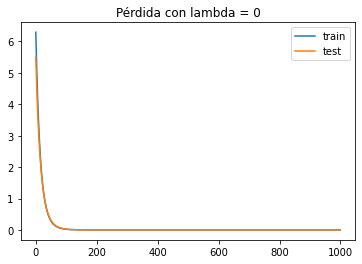

In [ ]:
plt.plot(loss_history, label = "train")
plt.plot(loss_test, label = "test")
plt.title('Pérdida con lambda = 0') # Regresión normal
plt.legend()

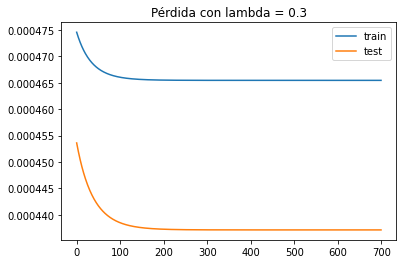

In [ ]:
plt.plot(loss_history[-700:], label = "train")
plt.plot(loss_test[-700:], label = "test")
plt.title('Pérdida con lambda = 0.3')
plt.legend()

# Dropout

Lo que hace el Dropout es "inutilizar" algunas neuronas, para que no afecten ni el paso de "forward" ni el de "backpropagation".

Esto se llevara a cabo utilizando una "máscara" que contendrá una cantidad de ceros aleatoria dependiendo de que cantidad de neuronas queramos utilizar.

Veamos lo que sería una máscara para multiplicar las entradas de las capas, de modo que sería como "matar" ciertas neuronas

In [ ]:
inputs = np.array([[1,2,3,4]])

In [ ]:
rate = 0.80

binary_mask = np.random.binomial( 1 , 0.8, size = inputs.size) 

binary_mask

array([0, 1, 0, 1])

In [ ]:
algo = np.ones((10,4))
for i in range(0,10):
  algo[i,:] = algo[i,:]*(i+1)

algo

array([[ 1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.],
       [ 4.,  4.,  4.,  4.],
       [ 5.,  5.,  5.,  5.],
       [ 6.,  6.,  6.,  6.],
       [ 7.,  7.,  7.,  7.],
       [ 8.,  8.,  8.,  8.],
       [ 9.,  9.,  9.,  9.],
       [10., 10., 10., 10.]])

In [ ]:
# Creemo lo que sería la matriz despues de multiplicarla por la máscara
aux = np.zeros(algo.shape)
for j in range(algo.shape[1]):
  aux[:,j] = algo[:,j] * binary_mask[j]

aux

array([[ 0.,  1.,  0.,  1.],
       [ 0.,  2.,  0.,  2.],
       [ 0.,  3.,  0.,  3.],
       [ 0.,  4.,  0.,  4.],
       [ 0.,  5.,  0.,  5.],
       [ 0.,  6.,  0.,  6.],
       [ 0.,  7.,  0.,  7.],
       [ 0.,  8.,  0.,  8.],
       [ 0.,  9.,  0.,  9.],
       [ 0., 10.,  0., 10.]])

Creemos un modelo con la clase anterior solo para ver como serían las máscaras que utilizaremos.

In [ ]:
model_prueba = NeuralNetwork(3, [6,5], 1)

In [ ]:
model_prueba.weights

[array([[-3.32277794, -0.59639743, -0.73347353, -0.13595898, -1.99460608,
          0.16829066],
        [ 0.14141139, -0.74249647,  0.4485804 ,  1.05145453, -0.93416679,
         -1.21489238],
        [-1.36604076, -1.42763166, -0.05907253, -1.04100058,  0.94927919,
         -3.28362569]]),
 array([[-1.478141  ,  0.93718963, -1.83040007, -0.66063254,  1.16497219],
        [-1.1713328 , -0.64652669,  0.30554165,  1.15752017,  1.48774974],
        [ 1.48195799,  0.62429482,  1.54983067,  0.10069903, -1.86401006],
        [ 0.92737886, -1.45911097,  1.28614961,  0.31446429, -1.67091   ],
        [-1.2726801 ,  0.27165538, -1.84241387,  0.83675394,  0.78822609],
        [ 0.81515   , -0.12176226, -1.50008303, -0.36706127, -0.80378334]]),
 array([[ 0.89733793],
        [-1.94721392],
        [ 0.26409988],
        [-1.04871872],
        [ 0.03539397]])]

In [ ]:
# Capas de nuestro modelo que son afectadas (solo las capas ocultas)
hidden_layers = [6, 5]
masks = [None]
for i in hidden_layers:
  masks.append(np.random.binomial( 1 , rate, size = i) / rate)

In [ ]:
masks

[None,
 array([1.25, 1.25, 1.25, 1.25, 1.25, 1.25]),
 array([1.25, 1.25, 1.25, 1.25, 1.25])]

In [ ]:
# Estas máscaras afectarán como entran los datos a la siguiente capa (deshabilita las neuronas que tiene 0 en la máscara)

# Es conveniente guardar la máscara como un atributo del objeto modelo, lo agregaremos
masks

[None,
 array([1.25, 1.25, 1.25, 1.25, 1.25, 1.25]),
 array([1.25, 1.25, 1.25, 1.25, 1.25])]

# Modificación de algoritmo para aceptar las máscaras

In [ ]:
# Nuestra función de perdida (Error cuadrátio medio)
def mse(y_hat, y):
    return np.mean((y - y_hat)**2 )

def d_mse(y_hat, y):
    return (1 / y_hat.shape[0]) * (1/y_hat.shape[-1]) * -2 * np.sum(y - y_hat, axis=0)

In [ ]:
def linear(x):
    return x


def d_linear(x):
    return np.ones_like(x)


def relu(x):
    return np.where(x > 0, x, 0)


def d_relu(x):
    return np.where(x > 0, 1, 0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [ ]:
# Creación de nuestra clase red, con metodos "forward" para avanzar sobre nuestra red, "backward" para optimizar parámetros, "predict" para lo obvio
class NeuralNetwork2:
    def __init__(self, input_size, hidden_sizes, output_size, dropout = 0):
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i + 1]
            self.weights.append(np.random.randn(n_in, n_out))
            self.biases.append(np.random.randn(1, n_out))
            self.tape = [None for _ in range(len(self.weights) + 1)]

        if hidden_sizes:
          self.hidden_sizes = hidden_sizes
          self.activations = [linear] + [relu for _ in range(len(self.weights) - 1)] + [linear]
          self.d_activations = [d_linear] + [d_relu for _ in range(len(self.weights) - 1)] + [d_linear]
        else:
          self.activations = [linear] + [linear]
          self.d_activations = [d_linear] + [d_linear]

        self.dropout = dropout
        masks = [None]
        for i in hidden_sizes:
          masks.append(np.random.binomial( 1 , 1-self.dropout, size = i) / (1 - modelo_pruebas.dropout) )  # Este "0.8" nos dice que apagaremos 1 neurona por cada 4 prendidas
        self.masks = masks

    def forward(self, x, grad=False):
        if grad and self.tape[0] is not None:
            raise ValueError("Cannot call forward with grad without calling backwards")

        if grad:
            self.tape[0] = x
        
        for i in range(len(self.weights)):
            # x es nuestro input, ese modificaremos con dropout
            if i > 0:
                aux = np.zeros(x.shape)
                for j in range(x.shape[1]):
                  aux[:,j] = x[:,j]*self.masks[i][j]
            else:
                aux = x.copy()

            #print('forward')
            #print(aux)
            #print('_______________')
            x_hat = aux @ self.weights[i] + self.biases[i]
            x = self.activations[i + 1](x_hat)
            if grad:
                self.tape[i + 1] = x_hat

        return x

    def backward(self, d_loss):
        assert d_loss.shape == self.weights[-1].shape[-1:]

        weights_grad = [None for w in self.weights]
        biases_grad = [None for b in self.biases]

        d_activation = self.d_activations[-1]
        error = d_loss * d_activation(self.tape[-1]) # (n_out) * (n_out)
        error = error.reshape(1, -1)

        for i in reversed(range(len(self.weights))):
            # error = (1, n_out)
            # tape[i] = (n_in)
            # weights[i] = (n_in, n_out)
            x = self.tape[i]

            if i > 0:
                aux = np.zeros(x.shape)
                for j in range(x.shape[1]):
                  aux[:,j] = x[:,j]*self.masks[i][j]
            else:
                aux = x.copy()

            #print('backward')
            #print(aux)
            #print('_______________')

            activation = self.activations[i]
            d_activation = self.d_activations[i]

            weights_grad[i] = error * activation(aux.reshape(-1, 1)) # (1, n_out) * (n_in, 1) -> (n_in, n_out) * (n_in, n_out) por broadcast -> (n_in, n_out)
            biases_grad[i] = error * 1 # derivada de los sesgos es un vector de unos, lo representamos explicitamente como 1 (uso de broadcasting)
            
            error = error @ self.weights[i].T  # (1, n_out) @ (n_out, n_in) -> (1, n_in)
            error = error * d_activation(aux).reshape(1, -1) # (1, n_in) * (1, n_in)


        self.tape = [None for _ in range(len(self.weights) + 1)]

        return weights_grad, biases_grad

    def predict(self, x):
        y = self.forward(x)
        return y # la salida sería "y"

In [ ]:
def compute_analytical_gradient(model, X, Y, batch_size, num_classes):
    analytical_weights_grad = [np.zeros(w.shape) for w in model.weights]
    analytical_biases_grad = [np.zeros(b.shape) for b in model.biases]

    batches = list(zip(X, Y))
    for i in range(0, len(batches), batch_size):
        batch = batches[i : i + batch_size]
        x, y = zip(*batch)
        x = np.array(x)
        y = np.array(y)
        y_one_hot = y   # cuando no sea problema de clasificación  #  one_hot_encode(y, num_classes)   cuando sea clasificación
        y_hat = model.forward(x, grad=True)

        weights_grad, biases_grad = model.backward(d_mse(y_hat, y_one_hot)) # CAMBIOS
        #print(modelo_pruebas.masks)
        #input()
        for l in range(len(model.weights)):
            analytical_weights_grad[l] += weights_grad[l]
            analytical_biases_grad[l] += biases_grad[l]

    for l in range(len(model.weights)):
        analytical_weights_grad[l] /= len(X)
        analytical_biases_grad[l] /= len(X)

    return analytical_weights_grad, analytical_biases_grad

In [ ]:
def stochastic_gradient_descent(model, X, Y, lr, batch_size, num_classes):
    analytical_weights_grad, analytical_biases_grad = compute_analytical_gradient(model, X, Y, batch_size, num_classes)

   # print(analytical_weights_grad)
   # print("-----------")
   # print(analytical_biases_grad)
   # print("###################")
    running_loss = 0
    for x, y in zip(X, Y):
        # one hot encode labels
        x = x.reshape(1, -1)
        y = y.reshape(1)
        #  y_one_hot = one_hot_encode(y, num_classes)   # solo en problemas de clasificación

        # feed forward
        y_hat = model.forward(x, grad=True)

        # compute loss and its derivative
        loss = mse(y_hat, Y)
        d_error = d_mse(y_hat, Y)
        running_loss = loss

        # backpropagate the error (update gradients)
        model.backward(d_error)

        # gradient descent step
        for i in range(len(model.weights)):
            # update weights
            model.weights[i] += lr * (-analytical_weights_grad[i])
            model.biases[i] += lr * (-analytical_biases_grad[i])

            # reset gradients
            # model.weights_grad[i].fill(0)
            # model.biases_grad[i].fill(0)
    print('###  Mátrices de los gradients que modificarán los pesos, los pesos que la neurona influye hacia atras no cambiarán  ########')
    for i in analytical_weights_grad: 
      print(i)
    print('################')
    return running_loss / len(X)

# Definición del modelo nuevo

In [ ]:
# Instanciamos el objeto "NeuralNetwork"
modelo_pruebas = NeuralNetwork2(3, [6,5], 1, dropout = 0.1) 
# La variable dropout representa el porcentaje de neuronas que queremos "matar"
# dropout debe estar en el intervalo [0,1), no puede ser 1 (matariamos todas las neuronas)

## IMPORTANTE:

En la siguiente celda de código lo que verán es como los pesos están siendo modificados en cada época, teniendo en cuenta que hay neuronas "muertas" dependiendo del dropout escogido. Verán que las mátrices tendrán columnas y filas de ceros, asi que vale la pena mencionar lo siguiente:

- Las columnas (verticales) significa como son afectados los gradientes por las neuronas a las que entrarán, 1 fila de ceros significa que la neurona a la que entrarán esos pesos está apagada

- Las filas de ceros, significa que son los pesos que hubiesen salido de una neurona, pero como está apagada, estos pesos no actuaron en esa época del entrenamiento, por lo que no deben ser modificados por ningún gradiente


También se imprime la máscara utilizada para cada época.

Hay una línea con un input, por si desean ver paso a paso como se realiza la modificación

TENGAN EN CUENTA que si un modelo tiene pocas neuronas, dropout grandes modifican mucho las cosas

In [ ]:
# Tiempo ejecuición aprox 55 seg por cada 1000 épocas
loss_history = []
loss_test = []

for epoch in range(1000):
    print(f'Época:  {epoch}') # Época del entrenamiento
    print(modelo_pruebas.masks) # Máscara para ésta epoca
    print('-------------')
    loss = stochastic_gradient_descent(modelo_pruebas, features_train, labels_train, lr=0.00001, batch_size=1 ,num_classes=1)
    print('-------------') # En linea anterior, se ve como se afectarían los gradientes al matar ciertas neuronas

    #input()  ## SI COMENTAN ESTE INPUT SE EJECUTARÁN TODAS LAS ÉPOCAS


    # En este bloque reiniciaremos las máscras para la próxima iteración
    mascaras_nuevas = [None]
    for i in modelo_pruebas.hidden_sizes:
      mascaras_nuevas.append(np.random.binomial( 1 , 1 - modelo_pruebas.dropout, size = i) / (1 - modelo_pruebas.dropout) ) 
    modelo_pruebas.masks = mascaras_nuevas


    loss_history.append(mse(labels_train, modelo_pruebas.predict(features_train)))

    loss_test.append(mse(labels_test, modelo_pruebas.predict(features_test)))

    if epoch % 100 == 0:
        print(f"epoch: {epoch} loss: {loss:.6f}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Época:  2762
[None, array([0.        , 1.11111111, 1.11111111, 1.11111111, 0.        ,
       1.11111111]), array([1.11111111, 1.11111111, 1.11111111, 1.11111111, 1.11111111])]
-------------
###  Mátrices de los gradients que modificarán los pesos, los pesos que la neurona influye hacia atras no cambiarán  ########
[[ 0.          0.50496118  0.5710857   0.42716389  0.          0.15236679]
 [ 0.          0.16076793  0.01708336  0.27115007  0.         -0.00241203]
 [ 0.         -0.2998018  -0.11760828  0.11593179  0.         -0.25862213]]
[[ 0.          0.          0.          0.          0.        ]
 [-0.12044108  0.          0.99175924 -0.00804794  0.55604715]
 [-1.94353305  0.          1.63892536 -0.77656364  0.04880535]
 [-0.05515438  0.          0.5214765  -0.00360892  0.27469901]
 [ 0.          0.          0.          0.          0.        ]
 [-1.47460699  0.          2.09955539 -1.23756019  1.17717171]]
[[ 5.596548

In [ ]:
import matplotlib.pyplot as plt

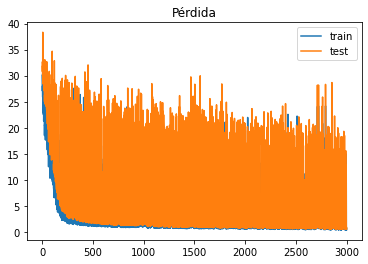

In [ ]:
plt.plot(loss_history, label = "train")
plt.plot(loss_test, label = "test")
plt.title('Pérdida') 
plt.legend()

In [ ]:
# Pérdida incial vs las pérdidas del as últimas 10 épocas en datos de entrenamiento (train)
loss_history[0], loss_history[-10:]

(30.068916758089667,
 [0.5444402263700848,
  9.264654234122691,
  0.39912632529844805,
  10.206365233409052,
  0.4398036540752082,
  0.41719292674642167,
  14.935142097665798,
  0.4039439229937951,
  0.768811935415901,
  0.4097590846072101])

In [ ]:
# Pérdida incial vs las pérdidas del as últimas 10 épocas en datos de prueba (test)
loss_test[1], loss_test[-10:]

(31.65480082314413,
 [0.7977739650075703,
  15.582048939523522,
  0.5229821889897032,
  8.911477995290818,
  0.5563750566167591,
  0.5378935458258423,
  12.87331387042023,
  0.5317902158874621,
  0.9196505807120673,
  0.5377434547034329])

¿A que creen que se deban los cambios abruptos en la perdida?

In [ ]:
#@title Respuesta
# Se debe a que en las épocas donde no apago neuronas ajusta un poco mejor y despues corrige mas fuertemente si apago mas de una (al azar)